In [1]:
import torch
from policy_networks.mlp import PolicyNet
from torch import optim
from tasks import RandomMaze
import numpy as np
from tasks import Maze_config
from gvf_networks.tabular import Tabular
from utils import train_epoch
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# get gpu when available
if torch.cuda.is_available():
    use_gpu = True
    device = torch.device("cuda:0")
    print("GPU is available", flush=True)
else:
    use_gpu = False
    device = torch.device("cpu")
    print("no GPU found", flush=True)

no GPU found


In [3]:
# parameters
gammas = [0.98]
num_actions = 4
lr_adam = 5e-4
env_name = 'RandomMaze-v0'
size = 20
depth = 5
lr = {'sr': 0.3, 'gvfs': 0.6, 'Q': 0.1}
thresholds = {'sr': 0.6, 'gvfs': 0.1}
change = 50  # maze is changed every change epochs
batch_size = 1000
nb_epochs = 10000
nb_episodes_random_policy = 20

# for plotting purposes
x_grid,y_grid = np.meshgrid(np.linspace(20,480,size),np.linspace(20,480,size))

In [4]:
# declare gvf network
gvf_net = Tabular(size=size, num_actions=num_actions, depth=depth, gammas=gammas, 
                  thresholds=thresholds, lr=lr)

# declare policy network
logits_net = PolicyNet(4 + (depth + 1) * num_actions * len(gammas), num_actions).to(device)

# make optimizer
optimizer = optim.Adam(logits_net.parameters(), lr=lr_adam)

# define environment
env, L = RandomMaze.main(start_position='goal_position',env_name=env_name, size=size)

epoch: 494 	 loss: -27.100 	 return: -40.000 	 ep_len: 200.000


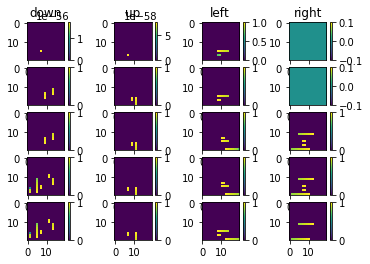

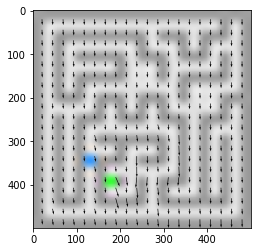

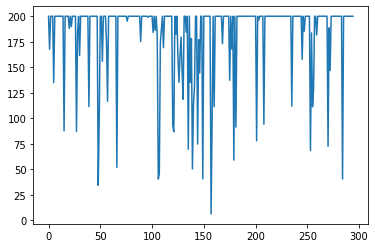

In [ ]:
total_reward = []

# training loop
for i in range(nb_epochs):
    clear_output(wait=True)
    
    # new network
    if i==0 or i%change==0:
        # reset gvf network
        gvf_net.reset()
        # new environment
        env, L = RandomMaze.main(start_position='goal_position',env_name=env_name, size=size)    
    elif np.any([(i-k)%change == 0 for k in range(1, 3)]): # for first 3 episodes, start at goal
        # set start position to goal
        Maze_config.start_idx = Maze_config.goal_idx
    else:
        # random new position
        Maze_config.start_idx = [L[np.random.randint(0, len(L))]]
        
    # training
    batch_loss, batch_rets, batch_lens = train_epoch(i, change, batch_size, env, gvf_net, logits_net, 
                                                     optimizer, device, nb_episodes_random_policy)

    print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
            (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))

    if np.all([(i - k) % change != 0 for k in range(nb_episodes_random_policy)]):
        total_reward.append(np.mean(batch_lens))

    policy_all_states = logits_net.get_policy_all_states(env, gvf_net)

    # figure of gvfs        
    img = env.render('rgb_array')     
    for i_plot in range(20):
        plt.subplot(5, 4, i_plot + 1)
        plt.imshow(gvf_net.gvfs[int(i_plot/4), :, :, -1, int(i_plot%4)])
        if i_plot <= 3:
            plt.title(np.array(['down', 'up', 'left', 'right'])[i_plot])
        plt.colorbar()

    # figure of policy network
    plt.figure()
    plt.imshow(img)
    plt.quiver(x_grid, 
               y_grid, 
               policy_all_states[:,:,3] - policy_all_states[:,:,2],
               policy_all_states[:,:,0] - policy_all_states[:,:,1])

    # figure of reward
    plt.figure()
    plt.plot(total_reward)
    plt.show()
